<a href="https://colab.research.google.com/github/Yospy/CT-Scans-3D-Image-Classification/blob/main/CT_Scans_3D_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
from numpy import *
import tensorflow as tf
from tensorflow import keras

In [2]:
normal_url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(),"NCT.zip")
keras.utils.get_file(filename,normal_url)

abnormal_url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(),"ANCT.zip")
keras.utils.get_file(filename,abnormal_url)

os.makedirs("MedicalData")

1045176320/1045162547 [==============================] - 19s 0us/step


In [3]:
with zipfile.ZipFile("NCT.zip","r") as z_fp:
  z_fp.extractall("./MedicalData/")

with zipfile.ZipFile("ANCT.zip","r") as z_fp:
  z_fp.extractall("./MedicalData/")

# Preprocessing and loading data

In [4]:
!pip install nibabel

import nibabel as nib

from scipy import ndimage

def read_nifti(filepath):
  scan = nib.load(filepath)
  scan = scan.get_fdata()

  return scan

def normalise(volume):
  min = -1000
  max = 400
  volume[volume<min] = min
  volume[volume>max] = max

  volume = (volume-min)/(max-min)
  volume = volume.astype("float32")
  return volume

def resize_vol(img):

  depth_des = 64
  height_des = 128
  width_des = 128

  cur_depth = img.shape[-1]
  cur_width = img.shape[0]
  cur_height = img.shape[1]

  depth = cur_depth/depth_des
  width = cur_width/width_des
  height = cur_height/height_des

  depth_factor = 1/depth
  width_factor = 1/width
  height_factor = 1/height

  img = ndimage.rotate(img, 90, reshape = False)

  img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
  return img


def process_scan(path):
    volume = read_nifti(path)

    volume = normalise(volume)

    volume = resize_vol(volume)

    return volume


In [5]:
normal_scanp = [
                os.path.join(os.getcwd(),"MedicalData/CT-0",x)
                for x in os.listdir("MedicalData/CT-0")
]

abnormal_scanp = [
                  os.path.join(os.getcwd(),"MedicalData/CT-23",x)
                  for x in os.listdir("MedicalData/CT-23")
]

print("CT scans with normal lung tissue:"+str(len(normal_scanp)))
print("CT scans with abnormal lung tissue:"+str(len(abnormal_scanp)))

CT scans with normal lung tissue:100
CT scans with abnormal lung tissue:100


In [6]:
normal_scan = array([process_scan(path) for path in normal_scanp])
abnormal_scan = array([process_scan(path) for path in abnormal_scanp])

normal_label = array([0 for _ in range(len(normal_scanp))])
abnormal_label = array([1 for _ in range(len(abnormal_scanp))])

x_train = concatenate((abnormal_scan[:70],normal_scan[:70]),axis=0)
y_train = concatenate((abnormal_label[:70],normal_label[:70]),axis=0)
x_test = concatenate((abnormal_scan[70:],normal_scan[70:]),axis=0)
y_test = concatenate((abnormal_label[70:],normal_label[70:]),axis=0)


In [7]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):

  def scipy_rotate(volume):

    angles = [-20,-10,-5,5,10,20]

    angle = random.choice(angles)
    volume = ndimage.rotate(volume,angle,reshape=False)
    volume[volume<0] = 0
    volume[volume>1] = 1
    return volume

  augment_vol = tf.numpy_function(scipy_rotate,[volume],tf.float32)
  return augment_vol


def train_pre(volume, label):
  volume = rotate(volume)
  volume = tf.expand_dims(volume,axis=3)
  return volume, label

def test_pre(volume, label):

  volume = tf.expand_dims(volume,axis=3)
  return volume, label

In [8]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_loader = tf.data.Dataset.from_tensor_slices((x_test,y_test))

batch_size = 2

train_data = (
    train_loader.shuffle(len(x_train))
    .map(train_pre)
    .batch(batch_size)
    .prefetch(2)
)

test_data = (
    test_loader.shuffle(len(x_test))
    .map(test_pre)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of CT scan is:  (128, 128, 64, 1)


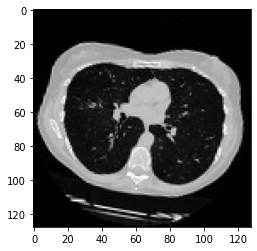

In [9]:
import matplotlib.pyplot as plt

data = train_data.take(4)
images,label = list(data)[3]
image = images.numpy()
image = images[0]
print("Dimension of CT scan is: ", image.shape)
plt.imshow(squeeze(image[:,:,30]),cmap='gray')

In [10]:
from tensorflow.keras import layers

def get_model(width=128,height=128,depth=64):

  inputs = keras.Input((width, height, depth, 1))

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=256, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)

  output = layers.Dense(1,activation='sigmoid')(x)


  model = keras.Model(inputs, output, name='3dcnn')
  return model 



model = get_model(width=128,height=128,depth=64)
model.summary()



Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [11]:
initial_lr = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['acc'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    '3d_image_classification.h5', save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc',patience=15)

epochs = 50
model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/50
70/70 - 54s - loss: 0.6870 - acc: 0.5357 - val_loss: 1.0663 - val_acc: 0.5000 - 54s/epoch - 777ms/step
Epoch 2/50
70/70 - 39s - loss: 0.6216 - acc: 0.6714 - val_loss: 2.0290 - val_acc: 0.5000 - 39s/epoch - 552ms/step
Epoch 3/50
70/70 - 38s - loss: 0.6492 - acc: 0.6214 - val_loss: 1.7884 - val_acc: 0.5000 - 38s/epoch - 547ms/step
Epoch 4/50
70/70 - 39s - loss: 0.6500 - acc: 0.6929 - val_loss: 1.5156 - val_acc: 0.5000 - 39s/epoch - 550ms/step
Epoch 5/50
70/70 - 38s - loss: 0.6073 - acc: 0.6857 - val_loss: 2.5940 - val_acc: 0.5000 - 38s/epoch - 538ms/step
Epoch 6/50
70/70 - 37s - loss: 0.6116 - acc: 0.6929 - val_loss: 0.6761 - val_acc: 0.6500 - 37s/epoch - 528ms/step
Epoch 7/50
70/70 - 37s - loss: 0.5999 - acc: 0.7071 - val_loss: 2.0122 - val_acc: 0.5000 - 37s/epoch - 530ms/step
Epoch 8/50
70/70 - 37s - loss: 0.6012 - acc: 0.7000 - val_loss: 1.2624 - val_acc: 0.5167 - 37s/epoch - 533ms/step
Epoch 9/50
70/70 - 38s - loss: 0.5852 - acc: 0.6786 - val_loss: 1.0259 - val_acc: 0.5167

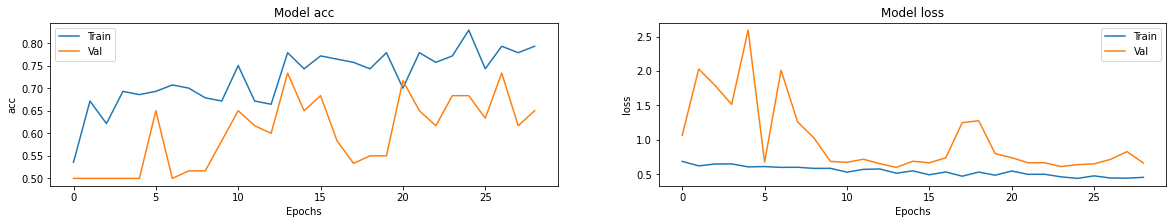

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,3))
ax = ax.ravel()

for i, metric in enumerate(['acc', 'loss']):
  ax[i].plot(model.history.history[metric])
  ax[i].plot(model.history.history["val_"+metric])
  ax[i].set_title("Model {}".format(metric))
  ax[i].set_xlabel("Epochs")
  ax[i].set_ylabel(metric)
  ax[i].legend(['Train', 'Val'])

# Make Predictions


In [20]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(expand_dims(x_test[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 67.73 percent confident that CT scan is normal
This model is 32.27 percent confident that CT scan is abnormal
